## Drop edges with no name data

First attempt is to make a simplified graph where we don't include edges which have no "name" from the TIGER data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import os, lzma, csv, collections, json
import numpy as np

import open_cp.network
import open_cp.geometry
import open_cp.sources.chicago
import matplotlib.patches
import shapely.geometry

import tilemapbase
import pyproj
proj = pyproj.Proj({"init":"epsg:3528"})

In [2]:
data_dir = os.path.join("/media", "OTHERDATA", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [35]:
# Don't want all locations, just unique ones!

with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    #data = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        if x < 10 or y < 10:
            continue
        out[block].append((x,y))
        #data.append((block, x, y, row[5], row[6], row[7]))
out = {k : np.asarray(list(set(out[k]))) / open_cp.sources.chicago._FEET_IN_METERS for k in out}
input_data = out
len(out)

51660

In [4]:
with open("chicago.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

with lzma.open("chicago_graph_names.xz", "rt") as f:
    edge_name_lookup = json.load(f)
edge_name_lookup = {int(k):v for k,v in edge_name_lookup.items()}
assert list(range(graph.number_edges)) == list(edge_name_lookup)

with lzma.open("chicago_graph_addresses.xz", "rt") as f:
    canonical_names_lookup = json.load(f)
canonical_names_lookup = {int(k):v for k,v in canonical_names_lookup.items()}
assert list(range(graph.number_edges)) == list(canonical_names_lookup)

## Make the reduced graph

In [5]:
none_edge_indices = set()
for e in range(graph.number_edges):
    if len(edge_name_lookup[e]) == 1 and edge_name_lookup[e][0] is None and canonical_names_lookup[5777][0] is None:
        none_edge_indices.add(e)
len(none_edge_indices)

170687

In [12]:
small_graph = open_cp.network.PlanarGraph(
    vertices = { (key,x,y) for key, (x, y) in graph.vertices.items() },
    edges = { (k1,k2) for e, (k1, k2) in enumerate(graph.edges) if e not in none_edge_indices }
    )
graph.number_edges, small_graph.number_edges

(942922, 772235)

In [15]:
projected = collections.defaultdict(list)
for key in out:
    for x, y in out[key]:
        (v1, v2), t = small_graph.project_point_to_graph(x, y)
        xx, yy = small_graph.edge_to_coords(v1, v2, t)
        projected[key].append((xx, yy))

In [16]:
names, geo = [], []
for key in projected:
    for (x,y) in projected[key]:
        names.append(key)
        geo.append( shapely.geometry.Point(x,y) )
        
frame = gpd.GeoDataFrame({"names":names})
frame.geometry = geo
frame.crs = {"init":"epsg:3528"}
frame.to_file("chicago_post_2001_to_simple_graph")

In [13]:
segments = list(open_cp.network.segment_graph(small_graph))
ordered_segments = list(open_cp.network.ordered_segment_graph(small_graph))

In [14]:
names, geo = [], []
for i, seg in enumerate(ordered_segments):
    geo.append( shapely.geometry.LineString([small_graph.vertices[x] for x in seg]) )
    names.append(i)
frame = gpd.GeoDataFrame({"segment" : names})
frame.geometry = geo
frame.crs = {"init":"epsg:3528"}
frame.to_file("chicago_simple_graph_segments")

# Find segments which contain an event

In [17]:
edge_to_block = collections.defaultdict(set)

for key in projected:
    for x, y in projected[key]:
        (v1, v2), _ = graph.project_point_to_graph(x, y)
        e, _ = graph.find_edge(v1, v2)
        edge_to_block[e].add(key)
        
edge_to_block = {k:v for k,v in edge_to_block.items()}

In [18]:
segments_we_want_by_edge = []

for segment in ordered_segments:
    out = []
    want = False
    for v1, v2 in zip(segment, segment[1:]):
        e, _ = graph.find_edge(v1, v2)
        out.append(e)
        if e in edge_to_block:
            want = True
    if want:
        segments_we_want_by_edge.append(out)

len(ordered_segments), len(segments_we_want_by_edge)

(141763, 45011)

# Form voroni

In [19]:
points = []
segments_by_voroni_pts = []
for segment in segments_we_want_by_edge:
    out = []
    for e in segment:
        v1, v2 = graph.edges[e]
        x1, y1 = graph.vertices[v1]
        x2, y2 = graph.vertices[v2]
        out.append( len(points) )
        points.append( ((x1+x2)/2, (y1+y2)/2) )
    segments_by_voroni_pts.append(out)
points = np.asarray(points)

voroni = open_cp.geometry.Voroni(points)

In [21]:
def project_to_tilemapbase(points):
    points = np.asarray(points)
    assert points.shape[-1] == 2
    xc, yc = proj(points[:,0], points[:,1], inverse=True)
    xcs, ycs = [], []
    for (x,y) in zip(xc, yc):
        x, y = tilemapbase.project(x, y)
        xcs.append(x)
        ycs.append(y)
    return np.asarray([xcs, ycs]).T

pt_wm = project_to_tilemapbase(points)

In [22]:
polygons_for_segments = []
for segment in segments_by_voroni_pts:
    polys = [shapely.geometry.Polygon(voroni.polygon_for(e)) for e in segment]
    poly = polys[0]
    for p in polys[1:]:
        poly = poly.union(p)
    polygons_for_segments.append(poly)

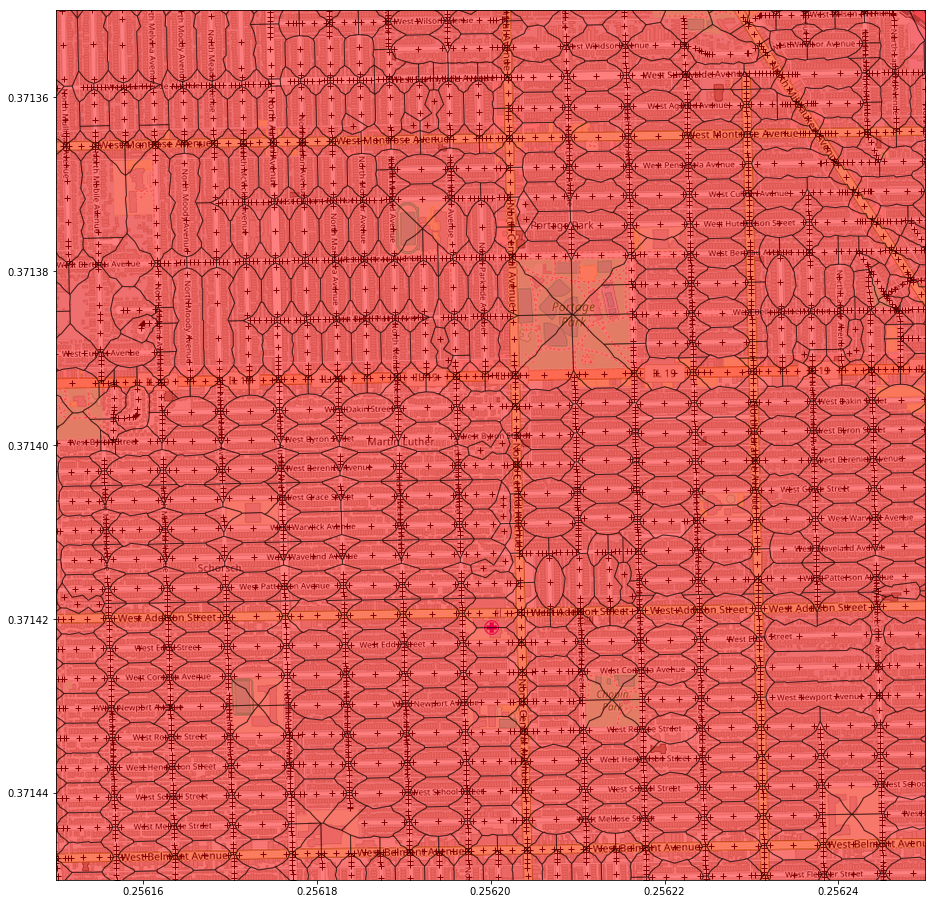

In [23]:
fig, ax = plt.subplots(figsize=(16,16))
ex = tilemapbase.Extent.from_centre(0.2562, 0.3714, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in polygons_for_segments:
    coords = []
    try:
        for poly in p:
            coords.append( list(poly.exterior.coords) )
    except:
        coords.append( list(p.exterior.coords) )
    for poly in coords:
        poly = project_to_tilemapbase(poly)
        x, y = poly[0]
        d = (x-0.2562)**2 + (y-0.3714)**2
        if d < 0.0001**2:
            p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
            ax.add_patch(p)
        
ax.scatter(*pt_wm.T, marker="+", color="black", linewidth=1)

In [24]:
frame = gpd.GeoDataFrame({"segment" : list(range(len(polygons_for_segments)))})
frame.geometry = polygons_for_segments
frame.crs = {"init":"epsg:3528"}
frame.to_file("chicago_regions_simple_segments")

### Conclusions

This does pretty well, I think.  The only major criticism is that I still want to merge some cells:

- Merge cells only when they touch
- Merge cells which have a "predominance" of the same "block" for the events they contain.

## Do some merging...

In [89]:
postfix = {" AV":"AVE", " BL":"BLVD", " BV":"BLVD", " STREET":"ST", "TR":"TER", "PW":"PKWY",
          "PK":"PARK"}
digit_remove = {"ST", "ND", "RD", "TH"}
replace = {" MARTN LUTHR ":" MARTIN LUTHER ", " MC LEAN ":" MCLEAN ",
            " LA CROSSE ":" LACROSSE ", " MONT CLARE ":" MONTCLARE ",
            " MC DOWELL ":" MCDOWELL ", " MC VICKER ":" MCVICKER "}

def normalise(key):
    key = key.upper()
    if key[-1] == ".":
        key = key[:-1]
    for f,t in postfix.items():
        if key.endswith(f):
            key = key[:-len(f)] + " " + t
    for f,t in replace.items():
        key = key.replace(f, t)
    for r in digit_remove:
        i = -1
        while True:
            i = key.find(r, i+1)
            if i == -1:
                break
            if key[i-1] in "0123456789":
                key = key[:i] + key[i+2:]
        
    for _ in range(10):
        key = key.replace("  ", " ")
    return key

assert normalise("ags  352 av") == "AGS 352 AVE"
assert normalise("BOB 51ST ST") == "BOB 51 ST"
assert normalise("01XX SHA ST.") == "01XX SHA ST"

In [90]:
# xmin, ymin, xmax, ymax
bounds = np.asarray([p.bounds for p in polygons_for_segments])
bounds.shape

(45011, 4)

In [91]:
ii = np.arange(len(polygons_for_segments))
polys_to_blocks = [collections.defaultdict(int) for _ in polygons_for_segments]
for key in input_data:
    pts = np.asarray(input_data[key])
    mask = bounds[:,0][:,None] <= pts[:,0][None,:]
    mask &= bounds[:,2][:,None] >= pts[:,0][None,:]
    mask &= bounds[:,1][:,None] <= pts[:,1][None,:]
    mask &= bounds[:,3][:,None] >= pts[:,1][None,:]
    mask = np.any(mask, axis=1)
    points = [shapely.geometry.Point(x, y) for x,y in input_data[key]]
    poly_indices = ii[mask]
    for i in poly_indices:
        count = sum(polygons_for_segments[i].intersects(pt) for pt in points)
        if count > 0:
            polys_to_blocks[i][normalise(key)] += count

In [92]:
polys_to_blocks[8865], polys_to_blocks[37779], polys_to_blocks[11223]

(defaultdict(int, {'037XX W 47 ST': 3}),
 defaultdict(int, {'037XX W 47 ST': 5}),
 defaultdict(int, {'047XX S HAMLIN AVE': 33}))

In [93]:
neighbours = []
for i, (xmin, ymin, xmax, ymax) in enumerate(bounds):
    poly = polygons_for_segments[i]
    mask = (xmax < bounds[:,0]) | (xmin > bounds[:,2])
    mask |= (ymax < bounds[:,1]) | (ymin > bounds[:,3])
    want = [j for j in ii[~mask] if poly.intersects(polygons_for_segments[j])]
    neighbours.append(want)

In [131]:
to_merge = [set() for _ in neighbours]
for i, nhood in enumerate(neighbours):
    blocks = set(polys_to_blocks[i].keys())
    for j in nhood:
        choices = blocks.intersection(set(polys_to_blocks[j].keys()))
        if i != j and len(choices) > 0:
            in_i = sum(polys_to_blocks[i][c] for c in choices)
            in_j = sum(polys_to_blocks[j][c] for c in choices)
            quality = in_i * in_j / (sum(polys_to_blocks[i].values()) * sum(polys_to_blocks[j].values()))
            if quality < 0.05 and (in_i < 10 or in_j < 10):
                pass
            else:
                to_merge[i].add(j)

In [133]:
# Check symmetric (numerical error messed this up!)
for i, options in enumerate(to_merge):
    for j in options:
        assert i in to_merge[j]

In [146]:
import networkx as nx
g = nx.Graph()
for i, _ in enumerate(to_merge):
    g.add_node(i)
for i, options in enumerate(to_merge):
    for j in options:
        g.add_edge(i, j)
        
merged_polys = []
for com in nx.connected_components(g):
    com = list(com)
    poly = polygons_for_segments[com[0]]
    for j in com[1:]:
        poly = poly.union(polygons_for_segments[j])
    merged_polys.append(poly)

In [148]:
frame = gpd.GeoDataFrame({"segment" : list(range(len(merged_polys)))})
frame.geometry = merged_polys
frame.crs = {"init":"epsg:3528"}
frame.to_file("chicago_regions_simple_segments_merged")

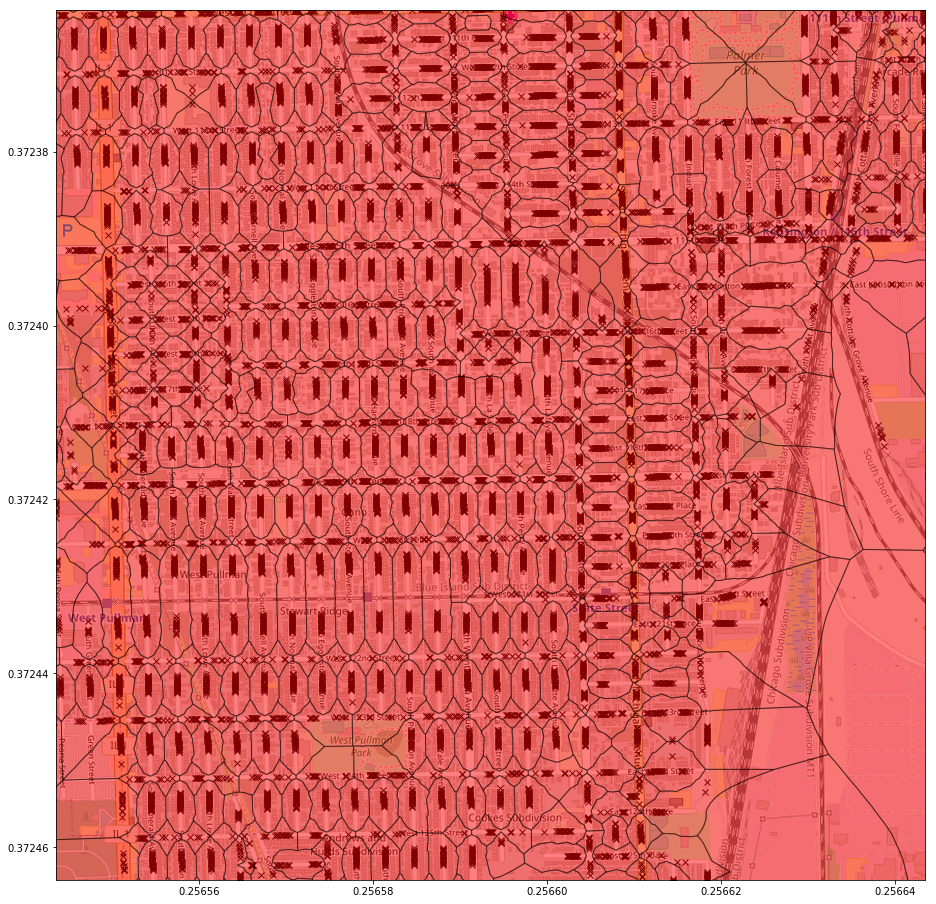

In [160]:
fig, ax = plt.subplots(figsize=(16,16))
xc, yc = 0.25659353,  0.37241373
ex = tilemapbase.Extent.from_centre(xc, yc, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in merged_polys:
    coords = []
    try:
        for poly in p:
            coords.append( list(poly.exterior.coords) )
    except:
        coords.append( list(p.exterior.coords) )
    for poly in coords:
        poly = project_to_tilemapbase(poly)
        x, y = poly[0]
        d = (x-xc)**2 + (y-yc)**2
        if d < 0.0001**2:
            p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
            ax.add_patch(p)

crime_pts = [tilemapbase.project(*proj(x, y, inverse=True))
             for key in input_data
             for x, y in input_data[key]
                ]
crime_pts = np.asarray(crime_pts)
ax.scatter(*crime_pts.T, marker="x", color="black", linewidth=1)

In [162]:
fig.savefig("example.pdf")